# Synthesizing a Wind Speed Time Series
[Florian Roscheck](https://www.linkedin.com/in/florianroscheck/), 2020-03-07

In this notebook, we use meteorological reference data from public sources to come up with artifical wind speed data for a ficitous measurement mast. The fictuous data is used only to show what measurement data of a wind mast usually looks like. The fictious mast is meant to be located in the San Diego, CA, area.

Note that there is a great body of scientific research on how to do this process the "right" way. However, sometimes a little goes a long way. Since we are not basing any scientific analyses on the data we create in this notebook, we can afford to only use a very basic modeling approach and make quite a few assumptions. None of the assumptions in this notebook are validated, so this is really just a hack to get something done quickly.

## Loading Reference Data

In this section, we load pre-processed reference data from ASOS and ERA5.

In [1]:
# Imports

import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

In [2]:
# Load ASOS measurement data

mets = []

for file in Path('../data/').glob('*_*_*.parquet'):
    mets.append(pd.read_parquet(file))

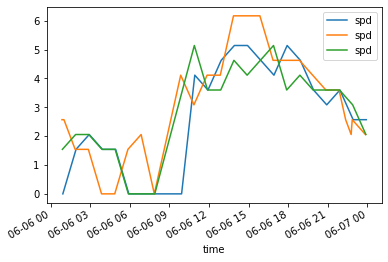

In [3]:
# Get initial look at the data

mets[0].dropna()['2015-06-06']['spd'].plot()
mets[1].dropna()['2015-06-06']['spd'].plot()
mets[2].dropna()['2015-06-06']['spd'].plot()
plt.legend()

There is a great amount of variance in the data. From personal experience, this does not resemble measurement mast data very well. We should bring in more reference data. Let's load the ERA5 data we downloaded.

In [4]:
# Load ERA5 data

era5_0 = pd.read_parquet('../data/era5_0.parquet')
era5_1 = pd.read_parquet('../data/era5_1.parquet')

## Coming up with a Model for Synthesizing Data

In this section, we do some analysis of the reference data to come up with a model of the wind speed that we can use for synthesizing data at the met mast.

Before proceeding, let's see how all data correlate with each other.

In [5]:
# Show correlations between ERA5 and ASOS data

print(era5_0['spd'].corr(mets[0].dropna()['spd']))
print(era5_0['spd'].corr(mets[1].dropna()['spd']))
print(era5_0['spd'].corr(mets[2].dropna()['spd']))
print(era5_1['spd'].corr(mets[0].dropna()['spd']))
print(era5_1['spd'].corr(mets[1].dropna()['spd']))
print(era5_1['spd'].corr(mets[2].dropna()['spd']))

0.7047452151657904
0.7299635456688818
0.6964357502128057
0.7491085628330746
0.7418533844904643
0.7000700401915071


It looks there is an acceptable (~0.7) correlation coefficient across the two sources, although it is not great. However, we have to keep in mind that all of the 5 sources we are considering are a little spread out across San Diego. Also, the ASOS stations are mounted close to the ground with potentially a significant impact of local roughness, so we can hardly expect great correlation coefficients (>0.9).

Now that we have 5 sources, let's combine them to get a smooth(er), single estimate of the wind speed that we can use later to guide our measurement mast synthesis.

In [6]:
# Bring speed data from all sources into a single DataFrame

all_spds = pd.concat([era5_0['spd'], 
                     era5_1['spd']], axis=1)

all_spds = all_spds.join(mets[0]['spd'].resample('h').mean().dropna(), rsuffix='1')
all_spds = all_spds.join(mets[1]['spd'].resample('h').mean().dropna(), rsuffix='2')
all_spds = all_spds.join(mets[2]['spd'].resample('h').mean().dropna(), rsuffix='3')

all_spds.columns = ['era5_0', 'era5_1', 'm0', 'm1', 'm2']

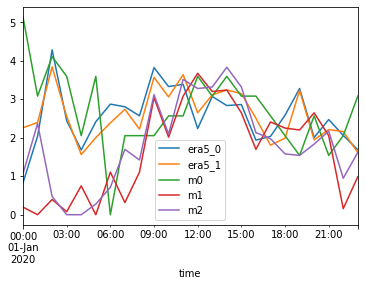

In [7]:
# Plot snapshot of all speeds

all_spds['2020-01-01'].plot()

Given the huge differences between the sources at every timestep (especially at night), it does not seem appropriate to take the mean of values at every timestep as a model. The median is a better choice.

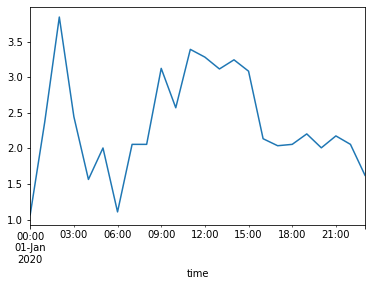

In [8]:
# Plot median of all speeds

all_spds['2020-01-01'].median(axis=1).plot()

That looks much better. Now, to avoid unrealistic correlation between the met mast and the 5 references, we need to add some noise.

### Adding Noise

Normally distributed noise is a great option because it does not change the character of the time series too much, as wind speed means remain the same.

When thinking about the amount of noise to add, however, it is important to understand that wind patterns differ across time and space. For example, at certain times of the day (typically around sunset or sunrise, when temperature gradients in the atmosphere are high), the air is relatively turbulent, causing greater spreads of wind speeds across the region. We need to be aware of this because we do not want to distort the median time series from above in any unrealistic way. So, at turbulent times we would like to introduce more noise than at non-turbulent times.

Using information from the reference data, we can assess the "typical" spread of data at each time step. A basic measure for spread in normal distributions is the standard deviation. Given that we do not know much about the data and thus cannot confirm if it is normally distributed, we just use the standard deviation as a model for spread.

It is still a challenge, however, that we only have at maximum 5 samples per time step, opening the door for measuring vastly different spreads between time steps. Given what we know about the atmosphere, we would not expect such vastly different spreads between hours of the day. At the cost of introducing a time lag and maybe missing some scenarios with actually steep gradients in turbulence (think a sudden storm), we can use a rolling window over the speed time series. Specifically, for every reference we determine the standard deviation of the last 4 hours and then take the median of those standard deviations to shape our noise for the speed time series.

Enough theory, let's add some noise!

In [9]:
# Add noise

syn = all_spds.median(axis=1)

stds = all_spds.rolling(4, axis=0).std().median(axis=1)
stds = stds.fillna(stds.median())

syn = syn + np.random.normal(loc=0.0, scale=stds)
syn = syn.clip(lower=0.0, axis=0)
syn.name = 'syn'

/Users/florian/.conda/envs/wra_in_python/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


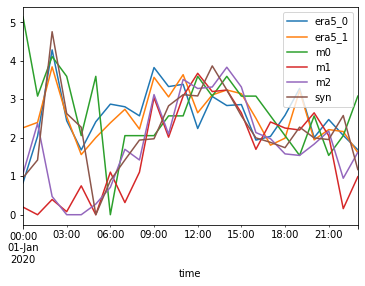

In [10]:
# Plot reference speeds and synthesized speed with noise

pd.concat([all_spds['2020-01-01'], syn['2020-01-01']], axis=1).plot()

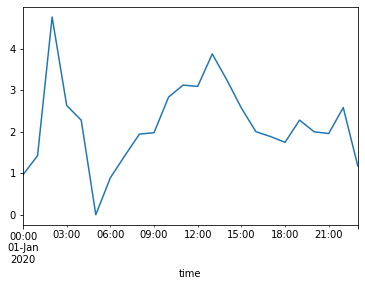

In [11]:
# Plot synthesized speed with noise only

syn['2020-01-01'].plot()

Is this time series realistic? Maybe. It is remarkable how quickly the wind fluctuates between hours of the day. We are also only looking at a single day and may have to look into more days to understand how good this time series really works.

But, remembering the objective to come up with a wind speed time series that looks somehow realistic for a measurement mast in a short time, it is time to move on.

## Modelling Wind Speed at Different Heights

In this section we ensure that we model wind speed at different heights in a realistic way.

Up until this section, we have neglected that there are differences in wind speed between different heights. We have even taken the median between AWOS (typically at 10 m height) and ERA5 (which was modelled at 100 m height)! This all sounds very sketchy. The good news is that we will take care of this right now.

We will first use our domain knowledge of the wind to scale our time series to a realistic wind speed and then extrapolate it to sensor heights that you would find on a wind mast.

### Scaling the Wind Speed

In wind resource assessment, the "mean of monthly means" (MoMM) is a great alternative to the mean, because it helps to understand the wind speed with regards to the different seasons of the year. Every season (=3 months) gets an equal vote, so that extremely high or low wind speeds in one season do not bias the mean too much.

In [12]:
# Define MoMM method

momm = lambda s: s.groupby(s.index.month).mean().mean()

In [13]:
# Get MoMM of synthesized time series

momm(syn)

2.6923113765183477

In [14]:
# Get MoMM of references

print(momm(era5_0['spd']))
print(momm(era5_1['spd']))
print(momm(mets[0].dropna()['spd']))
print(momm(mets[1].dropna()['spd']))
print(momm(mets[2].dropna()['spd']))

3.058668173725227
2.951632286717835
2.43683937446894
2.562769840452328
2.246028321229564


We would expect the MoMM of the 100 m high ERA5 references to be significantly higher than the MoMM at the 10 m level of the AWOS stations. However, the difference is only about 0.5 m. Is this realistic? Once again, it is hard to tell without knowing and analyzing a whole lot more. 

One thing that we can do at this point though, is deciding on a height that we want our synthesized time series to be at. We can just define this, but at a later step when we model the time series at different height levels, this height will matter.

Let's say that our synthesized time series should be at 10 m height. This would be close to the ASOS masts. Let's come up with a consensus estimate of the MoMM of the ASOS masts.

In [15]:
# Get 10 m MoMM of references

momm_10m = np.mean([momm(mets[0].dropna()['spd']), 
             momm(mets[1].dropna()['spd']), 
             momm(mets[2].dropna()['spd'])])
momm_10m

2.4152125120502776

Great, let's scale our synthesized time series to that number.

In [16]:
# Scale synthesiyed time series to 10 m MoMM of references

syn = syn * momm_10m/momm(syn)
momm(syn)

2.415212512050282

Perfect. The next step: Bringing the time series to different heights on the met tower.

### Extrapolating Synthesized Time Series to Measurement Heights

At a measurement mast, anemometers that measure the wind speed are typically placed at different heights. In our case, let's assume we have a 60 m measurement mast and anemometers are mounted at 30, 45, and 58 meters.

So, how do we get our 10 m time series to these heights? We can use wind shear information. Wind shear describes how wind speeds change with the elevation above ground.

The challenge for this analysis is: We do not have any good wind shear information. The ASOS met masts and the ERA5 model are all only measured at one height. So what should we do here? Let's come up with our own shear information. We make it up!

#### The Diurnal Wind Shear Profile

It so happens that nothing is that simple as just being able to assume a constant value for the shear -- that would be unrealistic! Usually, the wind shear varies by time of day. 

At night, the soil cools down and cold air from the upper atmosphere descends onto the earth undisturbed by the heat that is radiating from the soil during the hot daytime. As a result, the air mixes less and the winds blow more uniform. Under these conditions, wind speeds are very different at lower heights than they are at higher heights, meaning there is a relatively high wind shear. Due to the steady mixing of air during the daytime, there are less differences in wind speed between the different heights, resulting in a low wind shear. But how do we incorporate this knowledge into our wind speed model?

First, we need to find a proxy for shear. Interestingly enough, our diurnal wind speed profile (profile for each of the 24 h of the day), shows a pattern that matches to some extent the expected diurnal shear profile we talked about above:

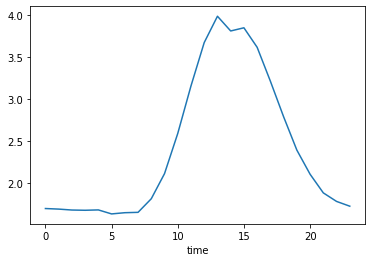

In [17]:
# Plot diurnal wind speed profile

syn.groupby(syn.index.hour).mean().plot()

We see high wind speeds during the day and low wind speeds at night -- the inverse of the shear profile. For a "typical" range of shear values between night and day we assume values between 0.180 and 0.200. (When we say "shear values" we actually mean the exponent of the[ wind profile power law](https://en.wikipedia.org/wiki/Wind_profile_power_law).) This assumption may be good or bad for the San Diego area, but for this notebook it does not matter much.

To transform the diurnal wind speed profile, we manually tune parameters `a` and `b` below until we have a range of shear values that is roughly between 0.180 and 0.200.

0.019713984242594962


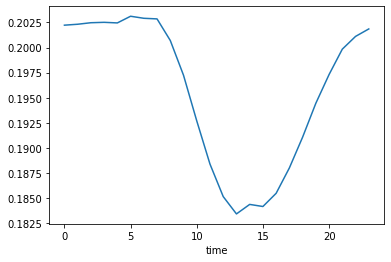

In [18]:
# Manually scale wind speed to shear profile

a = 0.115
b = 0.215

shear = (1/syn.groupby(syn.index.hour).mean()**a)*b
shear.plot()
print(shear.max()-shear.min())

Other than the dip around 2 pm and the unsmooth transition around 8 pm, this looks like an acceptable shear profile. Let's tune it a little manually to make it smoother.

In [19]:
# Display current shear

shear.to_dict()

{0: 0.20223144968864157,
 1: 0.20232453118655075,
 2: 0.20247581212139937,
 3: 0.20251591186344486,
 4: 0.20245628264768586,
 5: 0.20312243905004668,
 6: 0.20291895022542286,
 7: 0.20285774010999963,
 8: 0.20070421677301792,
 9: 0.19723718158998546,
 10: 0.19268786316040865,
 11: 0.1883771866897177,
 12: 0.18513719628211944,
 13: 0.18340845480745172,
 14: 0.18435647434272454,
 15: 0.1841477455541528,
 16: 0.1854659856012973,
 17: 0.18799642427906318,
 18: 0.1910651913544264,
 19: 0.19444727228838435,
 20: 0.19731145738082986,
 21: 0.1998416192961641,
 22: 0.2011114445771605,
 23: 0.20185635182392053}

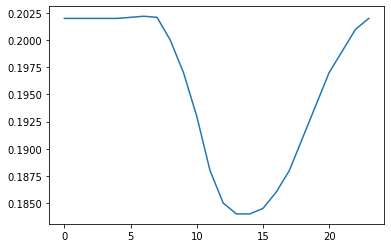

In [20]:
# Adust shear manually

shear_manual = \
{0: 0.202,
 1: 0.202,
 2: 0.202,
 3: 0.202,
 4: 0.202,
 5: 0.2021,
 6: 0.2022,
 7: 0.2021,
 8: 0.200,
 9: 0.197,
 10: 0.193,
 11: 0.188,
 12: 0.185,
 13: 0.184,
 14: 0.184,
 15: 0.1845,
 16: 0.186,
 17: 0.188,
 18: 0.191,
 19: 0.194,
 20: 0.197,
 21: 0.199,
 22: 0.201,
 23: 0.202}

shear_manual = pd.Series(shear_manual)
shear_manual.plot()

#### Applying the Wind Profile Power Law

Now that we have a diurnal shear profile we like, let's use it with the wind profile power law to extrapolate wind speeds at the heights of our fictious wind measurements on our mast.

To make the data more realistic, let's also add some normally distributed noise to the shear profile before using it in the power law.

In [21]:
# Apply Wind Profile Power Law to extrapolate 10 m wind speed to measurement heights

h_ref = 10
h_target = [30, 45, 58]

syn_target = {}
for h in h_target:
    tmp = pd.Series(index=syn.index, dtype=np.float64)
    for hour, shear in shear_manual.items():
        tmp[tmp.index.hour==hour] = syn[syn.index.hour==hour]*(h/h_ref)**(shear+np.random.normal(loc=0.0,scale=0.005, size=syn[syn.index.hour==hour].shape))
    syn_target[h] = tmp

In [22]:
# Show MoMMs again

for h, ts in syn_target.items():
    print('{}: {}'.format(h,momm(ts)))

30: 2.9857506134120313
45: 3.2289770140751846
58: 3.3910600890931764


Let's quickly check the MoMMs above against the 100 m MoMM we got from the ERA5 dataset.

In [23]:
momm(era5_0['spd'])

3.058668173725227

Looking at ERA5, the MoMMs of our sheared time series seem slightly unrealistic. Let's scale them down again to something between 2.4 (ASOS consensus) and 3.1 (ERA5).

In [24]:
# Scale synthesized time series to realistic MoMM speed

scaling_factor = 2.5/2.9

for h, ts in syn_target.items():
    syn_target[h] = ts*scaling_factor
    print('{}: {}'.format(h,momm(syn_target[h])))

30: 2.5739229425965786
45: 2.7836008742027443
58: 2.9233276630113614


Great. Let's see how this looks when we plot it.

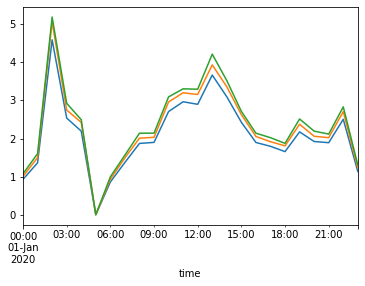

In [25]:
# Plot scaled time series

syn_target[30]['2020-01-01'].plot()
syn_target[45]['2020-01-01'].plot()
syn_target[58]['2020-01-01'].plot()

#### Adding More Noise

The time series above looks good, with one exception: It looks very uniform. Typically, wind measurements are not necessarily that uniform. Let's add a hint of noise to the three signals.

In [26]:
# Add more noise to time series

for h, ts in syn_target.items():
    syn_target[h] = ts+np.random.normal(loc=0.0,scale=0.02, size=ts.shape)

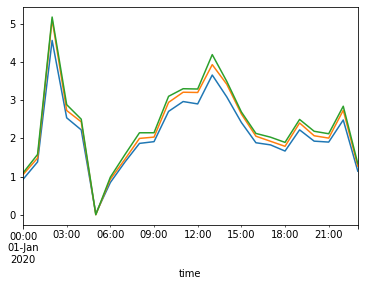

In [27]:
# Plot time series

syn_target[30]['2020-01-01'].plot()
syn_target[45]['2020-01-01'].plot()
syn_target[58]['2020-01-01'].plot()

## Upsampling the Time Series

We are almost at the end of the exercise. The last frontier: Upsampling the time series.

Typically, measurement data from met towers is in 10-minute intervals. Here however, we have data from the references in 1-hour intervals. How do we get the data into 10-minute intervals? By upsampling the data with pandas!

Let's use pandas *akima* method for upsampling our data to 10-minute data.

In [28]:
# Upsample synthesized data to 10-minute intervals

for h, ts in syn_target.items():
    syn_target[h] = ts.resample('10min').interpolate(method='akima')

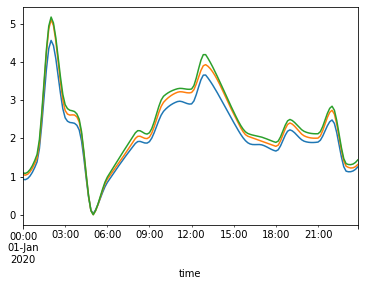

In [29]:
# Plot time series

syn_target[30]['2020-01-01'].plot()
syn_target[45]['2020-01-01'].plot()
syn_target[58]['2020-01-01'].plot()

Now, for the last time, let's add some noise. This time, we add uniform noise across all levels and add some Gaussian noise (normally distributes noise) to the individual channels.

In [30]:
# Add uniform and gaussian noise

noise = np.random.uniform(low=-0.12, high=0.12, size=syn_target[30].shape)

for h, ts in syn_target.items():
    syn_target[h] = ts+noise*ts*np.random.normal(loc=1.0,scale=0.05,size=ts.shape)+np.random.normal(loc=0.0,scale=0.03,size=ts.shape)

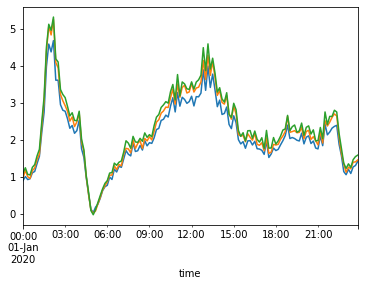

In [31]:
# Plot time series

syn_target[30]['2020-01-01'].plot()
syn_target[45]['2020-01-01'].plot()
syn_target[58]['2020-01-01'].plot()

This now looks like a time series that is similar to the one we would find at a met mast. Just to make sure we do not produce bad data, let's clip the lower bound of the speed values to 0.

In [32]:
# Clip lower bound of wind speed values

for h, ts in syn_target.items():
    syn_target[h] = ts.clip(lower=0.0)

## Adding Direction and Temperature Data

To complete the met mast, we need to add directional and temperature data. All of those need to be 10-minute time series, too.

### Temperature Data

For the temperature, we will just upsample the ERA5 temperature with a cubic spline and leave it like that.

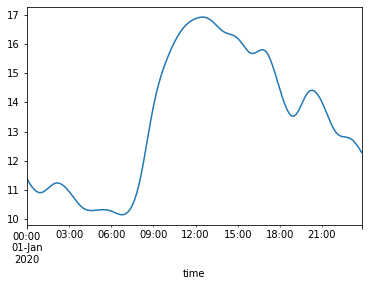

In [33]:
# Upsample temperature data

syn_temp = era5_0['tmp'].resample('10min').interpolate(method='cubic')
syn_temp['2020-01-01'].plot()

### Direction Data

For direction data, we take pandas' *akima* method and superimpose some Gaussian noise on it. A nuance with wind direction data is that it is typically less noisy when wind speeds are high. We account for that by scaling the superimposed noise by the ERA5 wind speed.

Directional data also tends to vary less with height, so we use the ERA5 wind speed as a basis. More adjustments can be done, especially in between measurement heights on the tower, but we defer from those here, since the scope of this workbook is synthesizing wind speed.

In [34]:
# Construct a noise scaling factor

noise_scaling_factor = ((1/era5_0['spd'].resample('10min').interpolate('linear'))**1.5)
noise_scaling_factor = noise_scaling_factor.clip(upper=1.0)
print(noise_scaling_factor.min())
print(noise_scaling_factor.quantile(0.25))
print(noise_scaling_factor.mean())
print(noise_scaling_factor.quantile(0.75))
print(noise_scaling_factor.max())

0.012442348776048398
0.1252917387013781
0.3200060933585722
0.40993824423261993
1.0


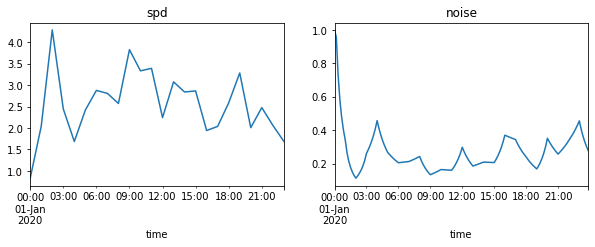

In [35]:
# Plot speed and noise data

_, ax = plt.subplots(1, 2, figsize=(10,3))
era5_0['spd']['2020-01-01'].plot(ax=ax[0], title='spd')
noise_scaling_factor['2020-01-01'].plot(ax=ax[1], title='noise')

The noise scaling factor distribution looks good, especially low wind speeds will be hit with a lot of noise. Let's make sure to scale the noise. Multiplying it with a factor of 30 yields a good-looking directional time series.

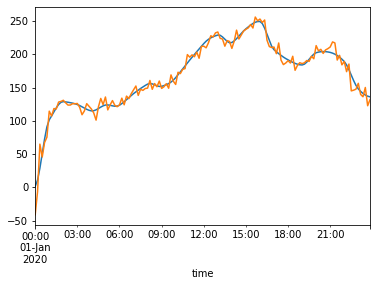

In [36]:
# Upsample wind direction and superimpose noise

dir_without_noise = era5_0['dir'].resample('10min').interpolate('akima')
dir_without_noise['2020-01-01'].plot()
dir_with_noise = dir_without_noise + np.random.normal(loc=0.0, scale=noise_scaling_factor)*30
dir_with_noise['2020-01-01'].plot()

Given that we added some noise, we should make sure the time series is between 0 and 360 deg.

In [37]:
# Make sure directional data is in 0 < x <= 360 interval

dir_with_noise[dir_with_noise<=0] = 360+dir_with_noise[dir_with_noise<=0]
dir_with_noise[dir_with_noise>360] = dir_with_noise[dir_with_noise>360]-360
print(dir_with_noise.min())
print(dir_with_noise.max())

0.00039869257886948617
359.99887016276847


## Exporting the Data

Let's merge and export the data to a Parquet file.

In [38]:
# Merge data into DataFrame

data = pd.DataFrame(syn_target)
data.columns=['spd_{}'.format(h) for h in syn_target.keys()]
data.loc[:,'tmp'] = syn_temp
data.loc[:,'dir'] = dir_with_noise
data.head()

,spd_30,spd_45,spd_58,tmp,dir
time,,,,,
1999-12-31 16:00:00,3.394928,3.727979,3.840262,12.370013,243.684999
1999-12-31 16:10:00,3.272444,3.647057,3.812246,12.223540,250.020154
1999-12-31 16:20:00,3.308469,3.626030,3.796200,12.117821,252.292915
1999-12-31 16:30:00,3.776605,4.259297,4.378676,12.043509,249.538686
1999-12-31 16:40:00,3.961894,4.380226,4.517085,11.991257,254.502181


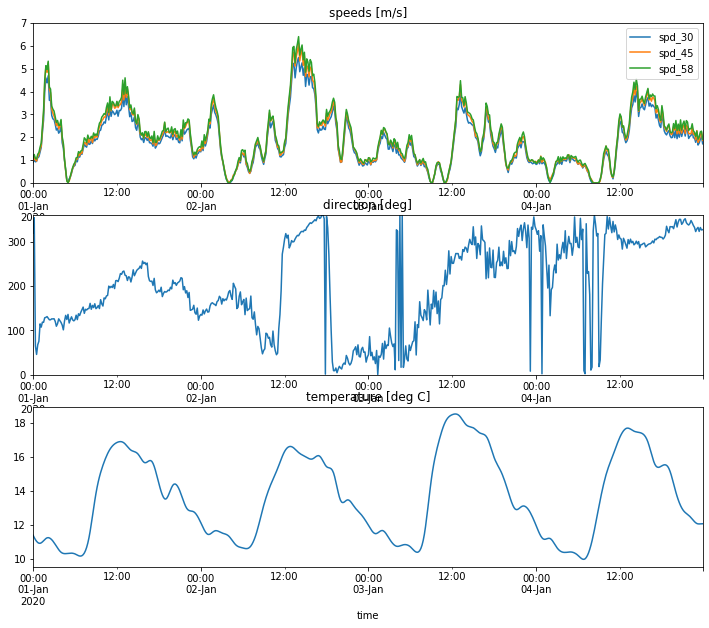

In [39]:
# Plot example data panel

_, ax = plt.subplots(3, 1, figsize=(12,10))
plot_data = data['2020-01-01':'2020-01-04']
plot_data[[c for c in plot_data.columns if c.startswith('spd')]].plot(ax=ax[0], title='speeds [m/s]')
plot_data['dir'].plot(ax=ax[1], title='direction [deg]')
plot_data['tmp'].plot(ax=ax[2], title='temperature [deg C]')
ax[0].set_ylim(0,7)
ax[1].set_ylim(0,360)
plt.show()

In [40]:
# Write data to parquet file

data.to_parquet('../data/met_mast.parquet')

## Final Thoughts

In our data synthesis, we have conciously left out some intricate details:

- Usually, anemometers that are mounted on met masts are influenced in a certain directional sector by the wake of the mast. We did not consider that.
- Shear is not only diurnal, but also directional. We have left that out, as it is usally a function of the topography surrounding the masts.
- Winter storms may cause instruments to ice up, resulting in erroneous data. We have not modelled any data outages.

Despite not diving into all of these details, the data are well usable for getting a feeling of how met mast data in the San Diego, CA, area might look like.